In [1]:
import random
import numpy as np
from ase import Atoms
from pymatgen.transformations.standard_transformations import SupercellTransformation
from pymatgen.io.ase import AseAtomsAdaptor
from ase.geometry.analysis import Analysis
from chgnet.model.model import CHGNet
from chgnet.model.dynamics import MolecularDynamics
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
import multiprocessing
import sys
from dask import delayed
from dask.distributed import Client, LocalCluster
import dask

sys.path.append("../")
from core import RotateStructure
from utils import create_spehircal_mesh_points

In [2]:
def get_structure(theta):
    rs = RotateStructure()
    return rs.get_rotated_structure(phi=0, theta=theta, remove_Rb=False, add_charge=False)


In [3]:
from chgnet.model.model import CHGNet
from chgnet.model.dynamics import MolecularDynamics
from pymatgen.core import Structure
from pymatgen.io.cif import CifWriter
import warnings
import matplotlib.pyplot as plt
from ase.io import read
from  pymatgen.io.ase import AseAtomsAdaptor

warnings.filterwarnings("ignore", module="pymatgen")
warnings.filterwarnings("ignore", module="ase")
chgnet = CHGNet.load()

def detect_phase_transition(structure, temperature_range, threshold=0.01,chgnet=chgnet):  # Added threshold parameter
    # Load the structure and the CHGNet model
    
    energies = []
    
    for temp in temperature_range:
        # Run MD simulation at the current temperature
        md = MolecularDynamics(
            atoms=structure,
            model=chgnet,
            ensemble="nvt",
            temperature=temp,
            timestep=2,
            trajectory=f"../data/md_files/md_{temp}K.traj",
            logfile=f"../data/md_files/md_{temp}K.log",
            loginterval=100,
            use_device="cpu",
        )
        md.run(100)
        
        # Update the structure with the final atomic positions after the MD run
        ase_atoms = read(f"../data/md_files/md_{temp}K.traj", index=-1)  # Read the last frame
        structure = AseAtomsAdaptor.get_structure(ase_atoms)
        
        # Predict the energy of the system after the MD run
        prediction = chgnet.predict_structure(structure)
        energy = prediction["e"]
        energies.append(energy)
    
    # Plot the energy vs temperature to observe any discontinuities
    plt.plot(temperature_range, energies, '-o')
    plt.xlabel("Temperature (K)")
    plt.ylabel("Total Energy (eV/atom)")
    plt.title("Energy vs Temperature")
    plt.show()
    
    # Check for phase transition by looking for a significant change in energy
    energy_diffs = [energies[i+1] - energies[i] for i in range(len(energies)-1)]
    transition_index = None
    for i, diff in enumerate(energy_diffs):
        if abs(diff) > threshold:
            transition_index = i
            break
    
    if transition_index is not None:
        print(f"Potential phase transition detected around {temperature_range[transition_index]}K.")
        ase_atoms = read(f"../data/md_files/md_{temperature_range[transition_index]}K.traj", index=-1)  # Read the last frame
        transitioned_structure = AseAtomsAdaptor.get_structure(ase_atoms)
        writer = CifWriter(transitioned_structure)
        writer.write_file("phase_transitioned_structure.cif")
        print("Phase transitioned structure saved to 'phase_transitioned_structure.cif'.")
    else:
        print("No phase transition detected.")


CHGNet initialized with 400,438 parameters


In [4]:
from chgnet.model.model import CHGNet
from chgnet.model.dynamics import MolecularDynamics
from pymatgen.core import Structure
from pymatgen.io.cif import CifWriter
import warnings
import matplotlib.pyplot as plt
from ase.io import read
from  pymatgen.io.ase import AseAtomsAdaptor

warnings.filterwarnings("ignore", module="pymatgen")
warnings.filterwarnings("ignore", module="ase")
chgnet = CHGNet.load()

def detect_phase_transition(structure, temperature_range, threshold=0.01,chgnet=chgnet):  # Added threshold parameter
    # Load the structure and the CHGNet model
    
    energies = []
    
    for temp in temperature_range:
        # Run MD simulation at the current temperature
        md = MolecularDynamics(
            atoms=structure,
            model=chgnet,
            ensemble="nvt",
            temperature=temp,
            timestep=2,
            trajectory=f"../data/md_files/md_{temp}K.traj",
            logfile=f"../data/md_files/md_{temp}K.log",
            loginterval=100,
            use_device="cpu",
        )
        md.run(100)
        
        # Update the structure with the final atomic positions after the MD run
        ase_atoms = read(f"../data/md_files/md_{temp}K.traj", index=-1)  # Read the last frame
        structure = AseAtomsAdaptor.get_structure(ase_atoms)
        
        # Predict the energy of the system after the MD run
        prediction = chgnet.predict_structure(structure)
        energy = prediction["e"]
        energies.append(energy)
    
    # Plot the energy vs temperature to observe any discontinuities
    plt.plot(temperature_range, energies, '-o')
    plt.xlabel("Temperature (K)")
    plt.ylabel("Total Energy (eV/atom)")
    plt.title("Energy vs Temperature")
    plt.show()
    
    # Check for phase transition by looking for a significant change in energy
    energy_diffs = [energies[i+1] - energies[i] for i in range(len(energies)-1)]
    transition_index = None
    for i, diff in enumerate(energy_diffs):
        if abs(diff) > threshold:
            transition_index = i
            break
    
    if transition_index is not None:
        print(f"Potential phase transition detected around {temperature_range[transition_index]}K.")
        ase_atoms = read(f"../data/md_files/md_{temperature_range[transition_index]}K.traj", index=-1)  # Read the last frame
        transitioned_structure = AseAtomsAdaptor.get_structure(ase_atoms)
        writer = CifWriter(transitioned_structure)
        writer.write_file("phase_transitioned_structure.cif")
        print("Phase transitioned structure saved to 'phase_transitioned_structure.cif'.")
    else:
        print("No phase transition detected.")

CHGNet initialized with 400,438 parameters


In [87]:
from chgnet.model.model import CHGNet
from chgnet.model.dynamics import MolecularDynamics
from pymatgen.core import Structure
from pymatgen.io.cif import CifWriter
from ase.io import read
from pymatgen.io.ase import AseAtomsAdaptor
import warnings
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client

warnings.filterwarnings("ignore", module="pymatgen")
warnings.filterwarnings("ignore", module="ase")

# Initialize a Dask client
client = Client()

chgnet = CHGNet.load()

@dask.delayed
def run_md_and_get_energy(temp, structure, chgnet):
    # Run MD simulation at the current temperature
    md = MolecularDynamics(
        atoms=structure,
        model=chgnet,
        ensemble="nvt",
        temperature=temp,
        timestep=2,
        trajectory=f"../data/md_files/md_{temp}K.traj",
        logfile=f"../data/md_files/md_{temp}K.log",
        loginterval=100,
        use_device="cpu",
    )
    md.run(200)
    
    # Update the structure with the final atomic positions after the MD run
    ase_atoms = read(f"../data/md_files/md_{temp}K.traj", index=-1)  # Read the last frame
    structure = AseAtomsAdaptor.get_structure(ase_atoms)
    
    # Predict the energy of the system after the MD run
    prediction = chgnet.predict_structure(structure)
    energy = prediction["e"]
    
    return energy

/opt/homebrew/Caskroom/miniconda/base/envs/dft/lib/python3.8/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54611 instead
  warnings.warn(


CHGNet initialized with 400,438 parameters


In [6]:
def detect_phase_transition(structure, temperature_range):
    # Prepare arguments for parallel processing
    args_list = [(temp, structure, chgnet, 0.01) for temp in temperature_range]
    
    
    # Parallelize the MD runs over all available cores
    results = [run_md_and_get_energy(temp, structure, chgnet) for temp in temperature_range]
    energies = dask.compute(*results)
    plt.plot(temperature_range, energies, '-o')
    plt.xlabel("Temperature (K)")
    plt.ylabel("Total Energy (eV/atom)")
    plt.title("Energy vs Temperature")
    plt.show()
    
    # Check for phase transition by looking for a significant change in energy
    energy_diffs = [energies[i+1] - energies[i] for i in range(len(energies)-1)]
    plt.plot(temperature_range[:-1], energy_diffs, '-o')
    plt.xlabel("Temperature (K)")
    plt.ylabel("Energy Difference (eV/atom)")
    plt.title("Energy Difference vs Temperature")
    plt.show()

CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu


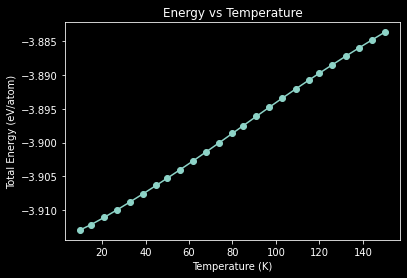

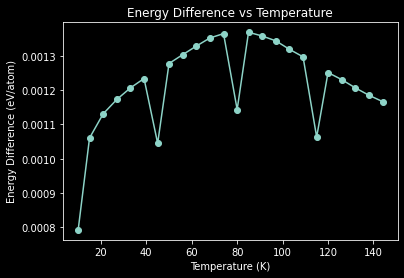

In [90]:
structure = get_structure(0)
temperature_range = [int(t) for t in np.linspace(10, 150, 25)]
detect_phase_transition(structure, temperature_range)

## Let us slightly nudge the atoms 

In [5]:
from pymatgen.analysis.local_env import VoronoiNN, LocalStructOrderParams

def get_ge_octahedral_order(structure):
    """
    Compute the octahedral order parameter for Ge atoms in the given structure.
    """
    vnn = VoronoiNN(cutoff=5)  # Using VoronoiNN to get neighbors
    lsop = LocalStructOrderParams(["oct"])  # Using "oct" for octahedral order parameter

    structure.remove_species(["Rb"])
    octahedral_orders = []

    for idx, site in enumerate(structure):
        if site.species_string == "Ge":
            neighbors_info = vnn.get_nn_info(structure, idx)
            neighbor_indices = [info['site_index'] for info in neighbors_info]
            op = lsop.get_order_parameters(structure, idx, indices_neighs=neighbor_indices)
            
            if op[0] is not None:  # Ensure the order parameter was computed
                octahedral_orders.append(op[0])

    return np.mean(octahedral_orders)  # Return average octahedral order for all Ge atoms

# Example usage:
structure = get_structure(180)  # Assuming you have a function to get the structure
octahedral_order = get_ge_octahedral_order(structure)
print(f"Average Ge octahedral order parameter: {octahedral_order}")


Average Ge octahedral order parameter: 0.34426444970055564


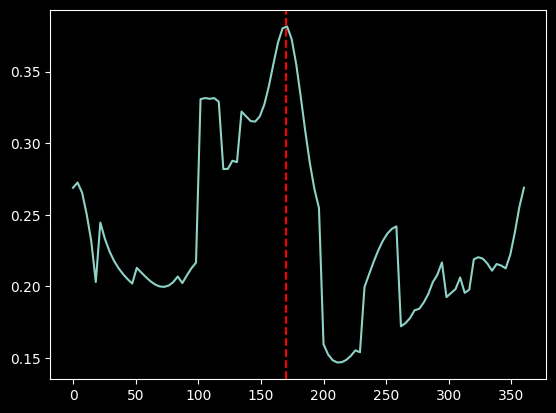

In [42]:
coord=[]
T=np.linspace(0,360,100)
for t in T:
    structure = get_structure(t)
    c=get_ge_octahedral_order(structure)
    coord.append(c)
plt.plot(T,np.array(coord))
plt.axvline(170,ls='--',c='r')

In [27]:
from pymatgen.io.cif import CifWriter
structure = get_structure(170)
CifWriter(structure).write_file("test.cif")
structure.remove_species(["Rb"])
vnn = VoronoiNN()
for idx, site in enumerate(structure):
        if site.species_string == "Ge":
            neighbors_info = vnn.get_nn_info(structure, idx)
            print(neighbors_info)

[{'site': PeriodicNeighbor: Cl5 (Cl) (3.316, -1.853, 3.665) [0.5881, -0.2575, 0.5641], 'image': (0, -1, 0), 'weight': 0.7560847149476398, 'site_index': 6, 'poly_info': {'normal': array([ 0.07770768, -0.67022706, -0.73807669]), 'solid_angle': 2.010333134157388, 'volume': 3.3921052525203716, 'face_dist': 1.3825544946455939, 'area': 7.360516924990886, 'n_verts': 4, 'verts': [516, 395, 393, 515], 'adj_neighbors': [4, 3, 2, 6]}}, {'site': PeriodicNeighbor: Cl3 (Cl) (3.316, 1.853, 3.665) [0.5881, 0.2575, 0.5641], 'image': (0, 0, 0), 'weight': 0.75608471494764, 'site_index': 4, 'poly_info': {'normal': array([ 0.07770768,  0.67022706, -0.73807669]), 'solid_angle': 2.0103331341573885, 'volume': 3.3921052525203708, 'face_dist': 1.3825544946455934, 'area': 7.360516924990887, 'n_verts': 4, 'verts': [692, 516, 515, 690], 'adj_neighbors': [5, 3, 1, 6]}}, {'site': PeriodicNeighbor: Cl1 (Cl) (0.8327, 0.0, 6.346) [0.1477, 0.0, 0.7905], 'image': (0, 0, 0), 'weight': 1.0, 'site_index': 2, 'poly_info': {'

In [6]:
from chgnet.model.model import CHGNet
from chgnet.model.dynamics import MolecularDynamics
from pymatgen.core import Structure
from pymatgen.io.cif import CifWriter
from ase.io import read
from pymatgen.io.ase import AseAtomsAdaptor
import warnings
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client
import numpy as np

warnings.filterwarnings("ignore", module="pymatgen")
warnings.filterwarnings("ignore", module="ase")

# Initialize a Dask client
client = Client()

chgnet = CHGNet.load()

@dask.delayed
def run_md_and_get_energy(temp, structure, chgnet, nudge_amount):
    # Nudge the atomic positions
    for atom in structure:
        atom.coords += np.random.uniform(-nudge_amount, nudge_amount, 3)
    
    # Run MD simulation at the current temperature
    md = MolecularDynamics(
        atoms=structure,
        model=chgnet,
        ensemble="nvt",
        temperature=temp,
        timestep=2,
        trajectory=f"../data/md_files/md_{temp}K.traj",
        logfile=f"../data/md_files/md_{temp}K.log",
        loginterval=100,
        use_device="cpu",
    )
    md.run(400)
    
    # Update the structure with the final atomic positions after the MD run
    ase_atoms = read(f"../data/md_files/md_{temp}K.traj", index=-1)  # Read the last frame
    structure = AseAtomsAdaptor.get_structure(ase_atoms)
    
    # Predict the energy of the system after the MD run
    prediction = chgnet.predict_structure(structure)
    energy = prediction["e"]
    
    coordination_number = get_coordination_number(structure)
    
    return energy, coordination_number

def detect_phase_transition(structure, temperature_range):
    # Prepare arguments for parallel processing
    args_list = [(temp, structure, chgnet, 0.05) for temp in temperature_range]
    
    # Parallelize the MD runs over all available cores
    results = [run_md_and_get_energy(*args) for args in args_list]
    results = dask.compute(*results)
    energies = [res[0] for res in results]
    coordination_numbers = [res[1] for res in results]

    
    fig, ax1 = plt.subplots()
    ax1.plot(temperature_range, energies, '-o', label="Energy")
    ax1.set_xlabel("Temperature (K)")
    ax1.set_ylabel("Total Energy (eV/atom)")
    ax1.set_title("Energy and Energy Gradient vs Temperature")
    
    ax2 = ax1.twinx()
    energy_diffs = [energies[i+1] - energies[i] for i in range(len(energies)-1)]
    ax2.plot(temperature_range[:-1], np.abs(energy_diffs), '-or', label="Energy Gradient",alpha=0.3)
    ax2.set_ylabel("Energy Difference (eV/atom)")
    
    ax3 = ax1.twinx()
    ax3.plot(temperature_range, coordination_numbers, '-og', label="Coordination Number")
    ax3.set_ylabel("Coordination Number (Ge-Cl)")
    ax3.spines['right'].set_position(('outward', 60))  # Move the second y-axis to the right a bit more

    
    fig.tight_layout()
    plt.show()
    return energies, coordination_numbers


CHGNet initialized with 400,438 parameters


CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpuCHGNet will run on cpu

CHGNet will run on cpu
CHGNet will run on cpu


/opt/homebrew/Caskroom/miniconda/base/envs/dft/lib/python3.8/site-packages/ase/md/nvtberendsen.py:95: RuntimeWarning: divide by zero encountered in double_scalars
  (self.temperature / old_temperature - 1.0) *
/opt/homebrew/Caskroom/miniconda/base/envs/dft/lib/python3.8/site-packages/ase/md/nvtberendsen.py:95: RuntimeWarning: divide by zero encountered in double_scalars
  (self.temperature / old_temperature - 1.0) *
2023-08-12 22:58:42,620 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-08-12 22:58:42,768 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-08-12 22:58:43,251 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-08-12 22:58:43,574 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-08-12 22:58:43,946 - distributed.utils_perf - WARNING -

CHGNet will run on cpu


2023-08-12 22:58:44,387 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-08-12 22:58:44,676 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


CHGNet will run on cpu
CHGNet will run on cpu


2023-08-12 22:58:45,053 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-08-12 22:58:45,595 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-08-12 22:58:45,983 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


CHGNet will run on cpu


2023-08-12 22:58:46,510 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-08-12 22:58:47,048 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-08-12 22:58:47,269 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-08-12 22:58:47,827 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-08-12 22:58:47,959 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
/opt/homebrew/Caskroom/miniconda/base/envs/dft/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:4141: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dft/lib/python3.8/site-packages/pymatgen/analysis/local_e

CHGNet will run on cpu
CHGNet will run on cpu


/opt/homebrew/Caskroom/miniconda/base/envs/dft/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:4141: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dft/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:3935: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(


CHGNet will run on cpu


2023-08-12 22:58:49,545 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-08-12 22:58:49,674 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-08-12 22:58:50,233 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-08-12 22:58:50,298 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


CHGNet will run on cpu


2023-08-12 22:58:50,933 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-08-12 22:58:51,212 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-08-12 22:58:51,642 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-08-12 22:58:51,892 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-08-12 22:58:52,329 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-08-12 22:58:52,518 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-08-12 22:58:53,145 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-08-12 22:58:53,160 - distributed.utils_perf - WARNING - full garbage collections took

CHGNet will run on cpu


2023-08-12 22:59:13,907 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-08-12 22:59:13,998 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


CHGNet will run on cpu


2023-08-12 22:59:14,609 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-08-12 22:59:14,631 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


CHGNet will run on cpu
CHGNet will run on cpu


2023-08-12 22:59:15,424 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-08-12 22:59:15,476 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-08-12 22:59:16,136 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-08-12 22:59:16,214 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-08-12 22:59:16,868 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-08-12 22:59:17,065 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-08-12 22:59:17,982 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-08-12 22:59:18,705 - distributed.utils_perf - WARNING - full garbage collections took

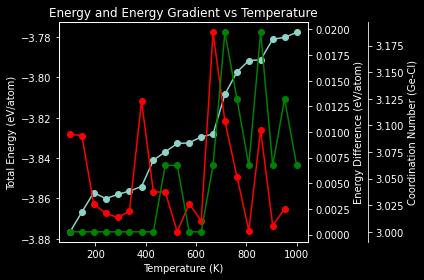

In [97]:
structure = get_structure(180)
structure = structure * (2,2, 2)
temperature_range = [int(t) for t in np.linspace(300, 800, 15)]
detect_phase_transition(structure, temperature_range)

### Smoothing out the curves

In [7]:
from chgnet.model.model import CHGNet
from chgnet.model.dynamics import MolecularDynamics
from pymatgen.core import Structure
from pymatgen.io.cif import CifWriter
from ase.io import read
from pymatgen.io.ase import AseAtomsAdaptor
import warnings
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client
import numpy as np

warnings.filterwarnings("ignore", module="pymatgen")
warnings.filterwarnings("ignore", module="ase")


chgnet = CHGNet.load()

@dask.delayed
def run_md_and_get_energy(temp, structure, chgnet, nudge_amount, runs=10,calculate_coordination_number=True):
    energies = []
    coordination_numbers = []
    
    for _ in range(runs):
        # Nudge the atomic positions
        for atom in structure:
            atom.coords += np.random.uniform(-nudge_amount, nudge_amount, 3)

        # Run MD simulation at the current temperature
        md = MolecularDynamics(
            atoms=structure,
            model=chgnet,
            ensemble="nvt",
            temperature=temp,
            timestep=2,
            trajectory=f"../data/md_files/md_{temp}K.traj",
            logfile=f"../data/md_files/md_{temp}K.log",
            loginterval=100,
            use_device="cpu",
        )
        md.run(100)  # Increased simulation time

        # Update the structure with the final atomic positions after the MD run
        ase_atoms = read(f"../data/md_files/md_{temp}K.traj", index=-1)
        structure = AseAtomsAdaptor.get_structure(ase_atoms)

        # Predict the energy of the system after the MD run
        prediction = chgnet.predict_structure(structure)
        energy = prediction["e"]
        if calculate_coordination_number:
            try:
                coordination_number = get_ge_octahedral_order(structure)
            except:
                coordination_number=0
        else:
            coordination_number = 0

        energies.append(energy)
        coordination_numbers.append(coordination_number)

    # return np.mean(energies), np.mean(coordination_numbers)
    return energies, coordination_numbers

def detect_phase_transition(structure, temperature_range):
    args_list = [(temp, structure, chgnet, 0.008) for temp in temperature_range]
    
    results = [run_md_and_get_energy(*args) for args in args_list]
    results = dask.compute(*results)
    
    energy_means = [np.mean(res[0]) for res in results]
    energy_vars = [np.var(res[0]) for res in results]
    
    coordination_means = [np.mean(res[1]) for res in results]
    coordination_vars = [np.std(res[1]) for res in results]

    fig, ax1 = plt.subplots()
    ax1.plot(temperature_range, energy_means, '-o', label="Energy Mean")
    ax1.fill_between(temperature_range, np.array(energy_means) - np.array(energy_vars), np.array(energy_means) + np.array(energy_vars), color='blue', alpha=0.2)
    ax1.set_xlabel("Temperature (K)")
    ax1.set_ylabel("Total Energy (eV/atom)")
    ax1.set_title("Energy and Coordination Number vs Temperature")

    ax3 = ax1.twinx()
    ax3.plot(temperature_range, coordination_means, '-og', label="Coordination Number Mean")
    ax3.fill_between(temperature_range, np.array(coordination_means) - np.array(coordination_vars), np.array(coordination_means) + np.array(coordination_vars), color='green', alpha=0.2)
    ax3.set_ylabel("Coordination Number (Ge-Cl)")

    fig.tight_layout()
    plt.show()
    return energy_means,energy_vars, coordination_means,coordination_vars

CHGNet initialized with 400,438 parameters


CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will

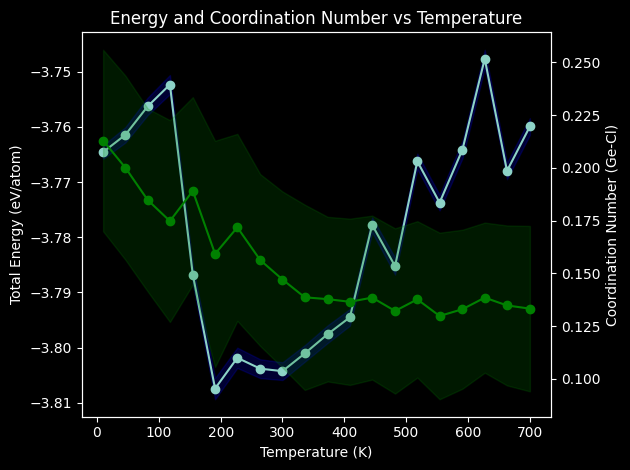

In [44]:
structure = get_structure(180)
structure = structure * (2,2, 2)
temperature_range = [int(t) for t in np.linspace(10, 700, 20)]
energy_means,energy_vars, coordination_means,coordination_vars=detect_phase_transition(structure, temperature_range)

CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will

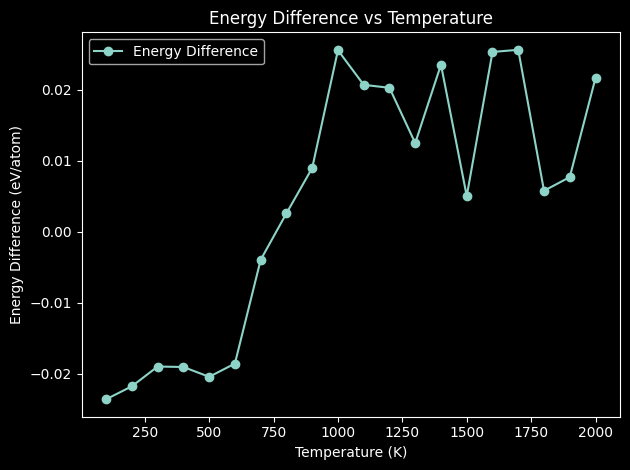

In [57]:
from dask import delayed, compute

def detect_phase_transition(structure1, structure2, temperature_range):
    args_list1 = [(temp, structure1, chgnet, 0.008,10,False) for temp in temperature_range]
    args_list2 = [(temp, structure2, chgnet, 0.008,10,False) for temp in temperature_range]
    
    results1 = [run_md_and_get_energy(*args) for args in args_list1]
    results2 = [run_md_and_get_energy(*args) for args in args_list2]
    
    results1 = dask.compute(*results1)
    results2 = dask.compute(*results2)
    
    energy_diffs = [np.mean(res1[0]) - np.mean(res2[0]) for res1, res2 in zip(results1, results2)]
    
    fig, ax1 = plt.subplots()
    ax1.plot(temperature_range, energy_diffs, '-o', label="Energy Difference")
    ax1.set_xlabel("Temperature (K)")
    ax1.set_ylabel("Energy Difference (eV/atom)")
    ax1.set_title("Energy Difference vs Temperature")
    ax1.legend()

    fig.tight_layout()
    plt.show()


    return energy_diffs


structure1=get_structure(0)
structure2=get_structure(180)
structure1 = structure1 * (2,2, 2)
structure2 = structure2 * (2,2, 2)
temperature_range = [int(t) for t in np.linspace(100, 2000, 20)]
energy_diffs = detect_phase_transition(structure1, structure2, temperature_range)


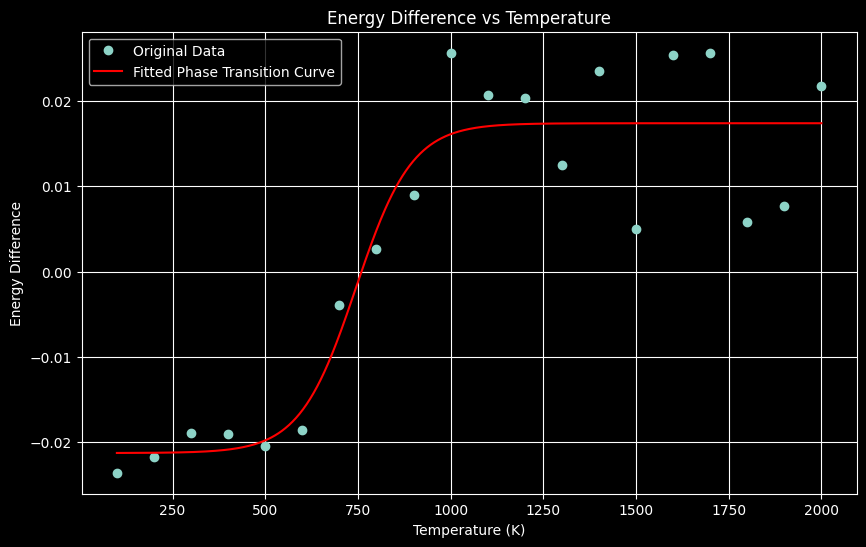

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def modified_sigmoid(x, L, k, x0, a):
    """Modified sigmoid function for phase transition fitting."""
    return a + (L - a) / (1 + np.exp(-k * (x - x0)))

def fit_and_interpolate(temperature_range, energy_diffs):
    """Fit the modified sigmoid function to the data and interpolate."""
    # Initial guess for parameters
    p0 = [max(energy_diffs), 0.01, temperature_range[np.argmax(energy_diffs)], min(energy_diffs)]
    
    # Fit the modified sigmoid function
    params, _ = curve_fit(modified_sigmoid, temperature_range, energy_diffs, p0=p0)
    
    # Interpolate the curve
    interpolated_temps = np.linspace(min(temperature_range), max(temperature_range), 1000)
    interpolated_energy_diffs = modified_sigmoid(interpolated_temps, *params)
    
    return interpolated_temps, interpolated_energy_diffs

def plot_energy_difference(temperature_range, energy_diffs, interpolated_temps, interpolated_energy_diffs):
    """Plot the original and interpolated energy difference curves."""
    plt.figure(figsize=(10,6))
    plt.plot(temperature_range, energy_diffs, 'o', label="Original Data")
    plt.plot(interpolated_temps, interpolated_energy_diffs, '-r', label="Fitted Phase Transition Curve")
    plt.xlabel("Temperature (K)")
    plt.ylabel("Energy Difference")
    plt.title("Energy Difference vs Temperature")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
temperature_range = [int(t) for t in np.linspace(100, 2000, 20)]
interpolated_temps, interpolated_energy_diffs = fit_and_interpolate(temperature_range, energy_diffs)
plot_energy_difference(temperature_range, energy_diffs, interpolated_temps, interpolated_energy_diffs)


### Order parameter coordination number

In [9]:
client = Client()
def detect_phase_transition(structure1, structure2, temperature_range):
    structure1_future = client.scatter(structure1)
    structure2_future = client.scatter(structure2)

    args_list1 = [(temp, structure1_future, chgnet, 0.008) for temp in temperature_range]
    args_list2 = [(temp, structure2_future, chgnet, 0.008) for temp in temperature_range]

    results1 = [run_md_and_get_energy(*args) for args in args_list1]
    results2 = [run_md_and_get_energy(*args) for args in args_list2]
    
    results1, results2 = dask.compute(results1, results2)
    
    energy_diffs = [np.mean(res1[0]) - np.mean(res2[0]) for res1, res2 in zip(results1, results2)]
    coordination_diffs = [np.mean(res1[1]) - np.mean(res2[1]) for res1, res2 in zip(results1, results2)]
    
    fig, ax1 = plt.subplots()
    ax1.plot(temperature_range, energy_diffs, '-o', label="Energy Difference")
    ax1.set_xlabel("Temperature (K)")
    ax1.set_ylabel("Energy Difference (eV/atom)")
    ax1.set_title("Energy and Coordination Number Differences vs Temperature")

    ax2 = ax1.twinx()
    ax2.plot(temperature_range, coordination_diffs, '-og', label="Coordination Number Difference")
    ax2.set_ylabel("Coordination Number Difference (Ge-Cl)")

    fig.tight_layout()
    plt.show()

    return energy_diffs, coordination_diffs

structure1=get_structure(0)
structure2=get_structure(180)
structure1 = structure1 * (2,2, 2)
structure2 = structure2 * (2,2, 2)

temperature_range = [int(t) for t in np.linspace(100, 1400, 20)]
energy_diffs, coordination_diffs = detect_phase_transition(structure1, structure2, temperature_range)
client.shotdown()

/opt/homebrew/Caskroom/miniconda/base/envs/dft/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54335 instead
  warnings.warn(


CHGNet will run on cpu
CHGNet will run on cpu


/opt/homebrew/Caskroom/miniconda/base/envs/dft/lib/python3.8/site-packages/ase/md/nvtberendsen.py:95: RuntimeWarning: divide by zero encountered in scalar divide
  (self.temperature / old_temperature - 1.0) *


CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu


/opt/homebrew/Caskroom/miniconda/base/envs/dft/lib/python3.8/site-packages/ase/md/nvtberendsen.py:95: RuntimeWarning: divide by zero encountered in scalar divide
  (self.temperature / old_temperature - 1.0) *
/opt/homebrew/Caskroom/miniconda/base/envs/dft/lib/python3.8/site-packages/ase/md/nvtberendsen.py:95: RuntimeWarning: divide by zero encountered in scalar divide
  (self.temperature / old_temperature - 1.0) *
/opt/homebrew/Caskroom/miniconda/base/envs/dft/lib/python3.8/site-packages/ase/md/nvtberendsen.py:95: RuntimeWarning: divide by zero encountered in scalar divide
  (self.temperature / old_temperature - 1.0) *


CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu


2023-08-13 12:27:28,934 - distributed.worker - WARNING - Compute Failed
Key:       run_md_and_get_energy-5afbaa10-835b-4235-afac-0f4e2b23f292
Function:  run_md_and_get_energy
args:      (1600, Structure Summary
Lattice
    abc : 11.828740000000003 14.39284 16.72286
 angles : 90.0 107.59318 90.0
 volume : 2713.8867102693976
      A : 11.275470234300366 0.0 -3.575312711219329
      B : -8.813072718319995e-16 14.39284 8.813072718319995e-16
      C : 0.0 0.0 16.72286
    pbc : True True True
PeriodicSite: Rb9 (Rb) (4.55, -0.005414, 1.688) [0.4035, -0.0003761, 0.1872]
PeriodicSite: Rb9 (Rb) (4.539, -2.17e-05, 10.04) [0.4026, -1.508e-06, 0.6865]
PeriodicSite: Rb9 (Rb) (4.533, 7.214, 1.688) [0.4021, 0.5012, 0.1869]
PeriodicSite: Rb9 (Rb) (4.536, 7.198, 10.04) [0.4022, 0.5001, 0.6862]
PeriodicSite: Rb9 (Rb) (10.19, 0.0009522, -0.106) [0.9039, 6.616e-05, 0.1869]
PeriodicSite: Rb9 (Rb) (10.18, -0.004234, 8.274) [0.9025, -0.0002942, 0.6877]
PeriodicSite: Rb9 (Rb) (10.17, 7.189, -0.08836) [0.902, 

CHGNet will run on cpu
CHGNet will run on cpu


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu


2023-08-13 12:27:37,500 - distributed.worker - WARNING - Compute Failed
Key:       run_md_and_get_energy-40a1e2d3-454a-4131-b0b5-bddf2904adbc
Function:  run_md_and_get_energy
args:      (2000, Structure Summary
Lattice
    abc : 11.828740000000003 14.39284 16.72286
 angles : 90.0 107.59318 90.0
 volume : 2713.8867102693976
      A : 11.275470234300366 0.0 -3.575312711219329
      B : -8.813072718319995e-16 14.39284 8.813072718319995e-16
      C : 0.0 0.0 16.72286
    pbc : True True True
PeriodicSite: Rb9 (Rb) (4.547, -0.00409, 1.69) [0.4032, -0.0002841, 0.1873]
PeriodicSite: Rb9 (Rb) (4.547, 0.001113, 10.04) [0.4033, 7.731e-05, 0.6868]
PeriodicSite: Rb9 (Rb) (4.548, 7.189, 1.685) [0.4034, 0.4995, 0.187]
PeriodicSite: Rb9 (Rb) (4.545, 7.198, 10.04) [0.4031, 0.5001, 0.6866]
PeriodicSite: Rb9 (Rb) (10.17, 0.007746, -0.1055) [0.9022, 0.0005382, 0.1866]
PeriodicSite: Rb9 (Rb) (10.18, -0.007754, 8.26) [0.9028, -0.0005387, 0.687]
PeriodicSite: Rb9 (Rb) (10.18, 7.198, -0.1078) [0.9028, 0.5001

CHGNet will run on cpu


2023-08-13 12:27:37,978 - distributed.worker - WARNING - Compute Failed
Key:       run_md_and_get_energy-3cb06659-bbbf-4ee8-99e2-0b37efd36abf
Function:  run_md_and_get_energy
args:      (2000, Structure Summary
Lattice
    abc : 11.828740000000003 14.39284 16.72286
 angles : 90.0 107.59318 90.0
 volume : 2713.8867102693976
      A : 11.275470234300366 0.0 -3.575312711219329
      B : -8.813072718319995e-16 14.39284 8.813072718319995e-16
      C : 0.0 0.0 16.72286
    pbc : True True True
PeriodicSite: Rb9 (Rb) (4.553, -0.001707, 1.696) [0.4038, -0.0001186, 0.1877]
PeriodicSite: Rb9 (Rb) (4.536, 0.006215, 10.04) [0.4023, 0.0004318, 0.6864]
PeriodicSite: Rb9 (Rb) (4.537, 7.209, 1.685) [0.4023, 0.5009, 0.1868]
PeriodicSite: Rb9 (Rb) (4.539, 7.19, 10.04) [0.4026, 0.4996, 0.6863]
PeriodicSite: Rb9 (Rb) (10.18, -0.003893, -0.1079) [0.9033, -0.0002705, 0.1867]
PeriodicSite: Rb9 (Rb) (10.17, -0.001002, 8.279) [0.9024, -6.961e-05, 0.688]
PeriodicSite: Rb9 (Rb) (10.17, 7.193, -0.08103) [0.9023, 

CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu


: 

CHGNet will run on cpuCHGNet will run on cpu
CHGNet will run on cpu

CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will

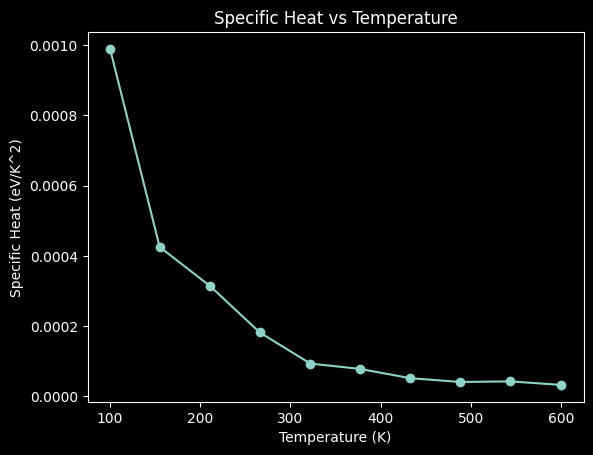

In [50]:
import numpy as np
import matplotlib.pyplot as plt

kB = 8.617333262145e-5  # Boltzmann constant in eV/K

def calculate_specific_heat(energies, temperature):
    avg_E = np.mean(energies)
    avg_E2 = np.mean(np.square(energies))
    Cv = (avg_E2 - avg_E**2) / (kB * temperature**2)
    return Cv

def plot_energy_distribution(energies, temperature):
    plt.hist(energies, bins=30, density=True, alpha=0.6, label=f"T = {temperature}K")
    plt.xlabel("Energy (eV/atom)")
    plt.ylabel("Probability Density")
    plt.title("Energy Distribution")
    plt.legend()
    plt.show()

def detect_phase_transition(structure, temperature_range):
    args_list = [(temp, structure, chgnet, 0.008, 20) for temp in temperature_range]  # 100 runs for each temperature
    
    results = [run_md_and_get_energy(*args) for args in args_list]
    results = dask.compute(*results)
    
    specific_heats = [calculate_specific_heat(res[0], temp) for res, temp in zip(results, temperature_range)]
    
    fig, ax1 = plt.subplots()
    ax1.plot(temperature_range, specific_heats, '-o', label="Specific Heat")
    ax1.set_xlabel("Temperature (K)")
    ax1.set_ylabel("Specific Heat (eV/K^2)")
    ax1.set_title("Specific Heat vs Temperature")
    plt.show()
    
    # Plot energy distribution for a couple of temperatures to check for bimodality
    for temp, res in zip(temperature_range, results):
        if temp in [300, 500]:  # Just an example, choose relevant temperatures
            plot_energy_distribution(res[0], temp)
    
    return specific_heats

# Assuming you have a function to get the structure
structure = get_structure(180)
structure = structure * (2,2, 2)
temperature_range = [int(t) for t in np.linspace(100, 600, 10)]
specific_heats = detect_phase_transition(structure, temperature_range)


In [61]:
import logging
client = Client(n_workers=8,silence_logs=logging.ERROR)
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [27]:
from chgnet.model.model import CHGNet
from chgnet.model.dynamics import MolecularDynamics
from pymatgen.core import Structure
from pymatgen.io.cif import CifWriter
from ase.io import read
from pymatgen.io.ase import AseAtomsAdaptor
import warnings
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client
import numpy as np


warnings.filterwarnings("ignore", module="pymatgen")
warnings.filterwarnings("ignore", module="ase")

# Initialize a Dask client


chgnet = CHGNet.load()

@dask.delayed
def run_md_and_get_energy(temp_start, temp_end, structure, chgnet, nudge_amount, segments=6):
    temp_step = (temp_end - temp_start) / segments
    energies = []
    coordination_numbers = []
    
    for segment in range(segments):
        current_temp = temp_start + segment * temp_step
        
        # Nudge the atomic positions
        for atom in structure:
            atom.coords += np.random.uniform(-nudge_amount, nudge_amount, 3)

        # Run MD simulation at the current temperature
        md = MolecularDynamics(
            atoms=structure,
            model=chgnet,
            ensemble="nvt",
            temperature=current_temp,
            timestep=2,
            trajectory=f"../data/md_files/md_{current_temp}K.traj",
            logfile=f"../data/md_files/md_{current_temp}K.log",
            loginterval=100,
            use_device="cpu",
        )
        md.run(100)  # Shorter duration for each segment

        # Update the structure with the final atomic positions after the MD run
        ase_atoms = read(f"../data/md_files/md_{current_temp}K.traj", index=-1)
        structure = AseAtomsAdaptor.get_structure(ase_atoms)

        # Predict the energy of the system after the MD run
        prediction = chgnet.predict_structure(structure)
        energy = prediction["e"]

        coordination_number = get_ge_octahedral_order(structure)

        energies.append(energy)
        coordination_numbers.append(coordination_number)

    return np.mean(energies), np.mean(coordination_numbers)

def detect_phase_transition(structure, temperature_range):
    # Reduced nudge_amount and finer temperature steps
    scattered_structure = client.scatter(structure)
    scattered_chgnet = client.scatter(chgnet)
    results = [run_md_and_get_energy(temp, temp+50, scattered_structure, scattered_chgnet, 0.01) for temp in temperature_range]
    
    results = dask.persist(*results)
    results = dask.compute(*results)
    
    energies = [res[0] for res in results]
    coordination_numbers = [res[1] for res in results]

    # Delete large objects and run the garbage collector
    del results

    # Apply a moving average to smooth out the coordination numbers
    window_size = 2
    smoothed_coordination_numbers = np.convolve(coordination_numbers, np.ones(window_size)/window_size, mode='valid')

    fig, ax1 = plt.subplots()
    ax1.plot(temperature_range, energies, '-o', label="Energy")
    ax1.set_xlabel("Temperature (K)")
    ax1.set_ylabel("Total Energy (eV/atom)")
    ax1.set_title("Energy and Energy Gradient vs Temperature")
    
    # ax2 = ax1.twinx()
    # energy_diffs = [energies[i+1] - energies[i] for i in range(len(energies)-1)]
    # ax2.plot(temperature_range[:-1], np.abs(energy_diffs), '-or', label="Energy Gradient", alpha=0.3)
    # ax2.set_ylabel("Energy Difference (eV/atom)")
    
    ax3 = ax1.twinx()
    ax3.plot(temperature_range[:len(smoothed_coordination_numbers)], smoothed_coordination_numbers, '-og', label="Coordination Number")
    ax3.set_ylabel("Coordination Number (Ge-Cl)")

    fig.tight_layout()
    plt.show()
    return energies, coordination_numbers


CHGNet initialized with 400,438 parameters


CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will run on cpu
CHGNet will

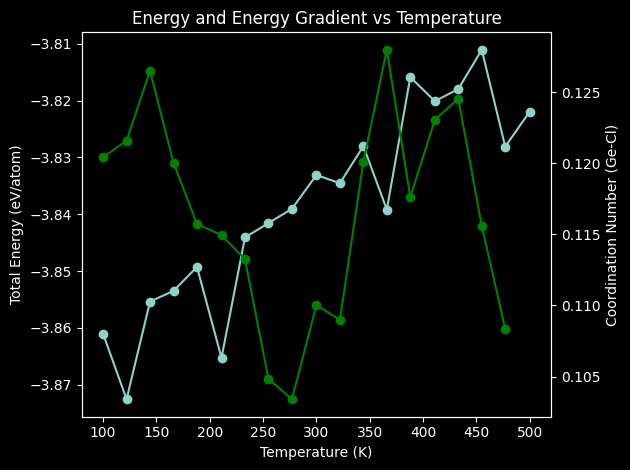

In [28]:
structure = get_structure(180)
structure = structure * (1,1,1)
temperature_range = [int(t) for t in np.linspace(100, 500, 19)]
energies, coordination_numbers=detect_phase_transition(structure, temperature_range)